# Modify the width of the code block(Can ignore)

In [101]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) #<--- Change the width value[0-100] to what you want.

---

# EfficentNetV2: Smaller Models and Faster Training
[(Tan, & Le,  2021)](https://arxiv.org/pdf/2104.00298.pdf)
<img src="Assets/m4.png" width="70%"/>

## Abstract
In EfficientNetV1, the author focus on accuracy, parameters efficiency and FLOPs, but FLOPs are only indirect indicators of inference speed and cannot be used as speed evaluation criteria([Ma, Zhang, Zheng,& Sun, 2018](https://arxiv.org/abs/1807.11164)).
1. **FLOPs do not consider important factors that may affect speed**
 * **MAC (memory access cost):** such as Group Conv, it will take up a lot of running time.
 * **Degree of parallelism:** Represents the number of repeated stacking of Operators in the current Stage. the measurement of how many operations a computer can perform at the same time. In the same FLOPs, models with high parallelism may be faster than models with low parallelism.
2. **Run on different hardware:** In the same FLOPs, different hardware platforms will have different speeds.

In EfficientNetV2, the author aim to imporve the training speed while maintaining the parameters efficiency. It can be seen from the table that V2 has greater advantages in training speed and inference speed compared to V1.

<img src="Assets/m7.png" width="40%"/>

### EfficientNetV2 is worth paying attention to
In the past research, the main focus was on accuracy and parameter performance. In recent years, the improvement in accuracy has reached saturation, and attention has begun to focus on the training speed and inference speed of the network.
1. Introduce the Fused-MBConv module
2. Introduce a progressive learning strategy (training faster)

## EfficientNetV1 vs EfficientNetV2
### 1. The training speed is very slow when the size of the training image is large.
Reduce the size of the training image to speed up the training and use a larger batch_size.

<img src="Assets/m8.png" width="60%"/>

### 2. Using Depthwise convolutions in the shallow layer of the network will be very slow.

Using **Depthwise convolutions** in shallow networks can be very slow. It is not possible to make the most of  the existing accelerators (In theory, FLOPs are small, but they are not as fast as expected in fact), so the author introduced **Fused-MBConv**.

<img src="Assets/m9.png" width="60%"/>

### 3. Scaling up each stage equally is sub-optimal.
In EfficientNetV1, the depth and width of each stage are scaling up equally. However, each stage has different effects on the training speed and parameters of the network, so the strategy of directly using the same scaling factor is unreasonable. So the author uses a non-uniform scaling factor strategy to scale the model.

<img src="Assets/m10.png" width="50%"/>

##### EfficientNetV1[(Tan, Le, 2019)](https://arxiv.org/pdf/1905.11946.pdf)
1. **input_size** represents the image size of the input network when training the network.
2. **width_coefficient** represents the scaling up factor in the channel.
3. **depth_coefficient** represents the scaling up factor in the depth.
4. **drop_connect_rate** is the drop_rate used by the dropout layer (Stochastic Depth) in the MBConv (increasing from 0 to drop_connect_rate).
5. **dropout_rate** is the dropout_rate of dropout layer before the last FC layer.

## Result
1. The New Neural NetWork - EfficentV2, performs better than the previous network in terms of training and parameters.
2. A method to improve progressive learning is proposed, which dynamically adjusts the regularization method（Dropout、Rand Augment、Mixup） according to the size of the image to improve the training speed and accuracy.
3. The training speed is increased by 11 times (EfficientNet V2-M is compared with EfficientNet-B7), and the amount of parameters is reduced to 1/6.8.

<img src="Assets/m11.png" width="50%"/>



***

# Model Implement

<h3>Note: The use of Swish must torch>1.7 </h3>

# Import libarary

In [102]:
import os
import sys
import glob
import platform

import json
import pickle

import random
import math

from collections import OrderedDict
from functools import partial
from typing import Callable, Optional

from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

import torch
import torch.nn as nn
from torch import Tensor

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from torch.utils.data import Dataset
import torchvision.transforms as transforms

from tqdm.notebook import tqdm

In [103]:
print(f"Pytorch version: {torch.__version__}")
if hasattr(nn, 'SiLU'):
    SiLU = nn.SiLU
    print("Support")
else:
    # For compatibility with old PyTorch versions
    print("Not Support, for compatibility with old PyTorch versions")
    class SiLU(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)

Pytorch version: 1.8.1
Support


## Deep Networks with Stochastic Depth

<img src="Assets/m2.png" width="50%" style="float: left;"/>

##### Deep Networks with Stochastic Depth[(Huang, Sun, Liu, Sedra,& Weinberger, 2019)](https://arxiv.org/pdf/1603.09382.pdf)
<p>
1. Improve training speed.<br>
2. Small increase in accuracy. <br>
3. In EfficientNetV2, drop_prob ranges from 0 to 0.2(red block).<br>
4. Applied to the layer called <b>DropOut</b> in Fused-MBConv and MBConv.
</p>

Drop paths (Stochastic Depth) per sample when applied in main path of residual blocks.
This function is taken from the [rwightman](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py#L140).

In [104]:
#================================================= * Define DropPath Function * =================================================#

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype = x.dtype, device = x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

#=================================================== * Define Model Class * =====================================================#

class DropPath(nn.Module):
    def __init__(self, drop_prob = None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
    
    def forward(self, x):
        #self.training: if set model.eval(), self.training = False
        return drop_path(x, self.drop_prob, self.training)  

## Squeeze-and-Excitation(SE)
<img src="Assets/m15.png" width="50%" style= "float:left"/>

##### Squeeze-and-Excitation Networks[(Hu, Shen, Albanie, Sun,& Wu, 2017)](https://arxiv.org/pdf/1709.01507.pdf)
<p>
1. Average Pooling<br>
2. The input channels of FC1 is <b>1/4 of the channels input to the MBConv</b>, and the <b>Swish</b> activation function is used.<br>
3. The input channels of FC2 is the <b>channels output of the Depthwise Conv(SE Input)</b>, and the <b>Sigmoid</b> activation function is used.
</p>    

In [105]:
class SqueezeExcite(nn.Module):
    def __init__(self,
                 input_channels: int,   # <------- MBConv Input channels.
                 expand_channels: int,  # <------- SE Inputchannels (DW Output channels).
                 se_ratio: float = 0.25):        
        super(SqueezeExcite, self).__init__()
        
        
        squeeze_channels = int(input_channels * se_ratio)
        
        #============================================ * Avg Polling * ================================================#        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        #=============================================== * FC1 * =====================================================#
        self.conv_reduce = nn.Conv2d(expand_channels, squeeze_channels, 1)
        self.act1 = SiLU()  # alias Swish
        
        #=============================================== * FC2 * =====================================================#
        self.conv_expand = nn.Conv2d(squeeze_channels, expand_channels, 1)
        self.act2 = nn.Sigmoid()

        
    def forward(self, x: Tensor) -> Tensor:
        #scale = x.mean((2, 3), keepdim=True) # Global polling
        scale = self.avg_pool(x)
        scale = self.conv_reduce(scale)      # FC1
        scale = self.act1(scale)             # Swish
        scale = self.conv_expand(scale)      # FC2
        scale = self.act2(scale)             # Sigmoid
        return scale * x

## Define Conv + BN + Act  Layer

In [106]:
class ConvBNAct(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int = 3,
                 stride: int = 1,
                 groups: int = 1,
                 norm_layer: Optional[Callable[..., nn.Module]] = None,
                 activation_layer: Optional[Callable[..., nn.Module]] = None):        
        super(ConvBNAct, self).__init__()

        padding = (kernel_size - 1) // 2        
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if activation_layer is None:
            activation_layer = SiLU

        self.conv = nn.Conv2d(in_channels  = in_channels,
                              out_channels = out_channels,
                              kernel_size  = kernel_size,
                              stride       = stride,
                              padding      = padding,
                              groups       = groups,
                              bias         = False)

        self.bn = norm_layer(out_channels)
        self.act = activation_layer()

    def forward(self, x):
        result = self.conv(x)
        result = self.bn(result)
        result = self.act(result)

        return result                                                                   

## MBConv Block
<img src="Assets/m14.png" width="60%"/>

##### EfficientNetV1[(Tan, Le, 2019)](https://arxiv.org/pdf/1905.11946.pdf)
MBConv is actually an improved version of **InvertedResidualBlock** in the MobileNetV3[(Howard, Sandler, Chu, Chen, Chen, Tan,...& Adam, 2019)](https://arxiv.org/pdf/1905.02244.pdf). The difference is that the Swish activation function is used in MBConv, and the SE (Squeeze-and-Excitation) module is added to each MBConv.

1. The first 1x1 convolutional layer used to increase the dimension, the number of convolution kernels is n times the input channel, n ∈ {1, 6}. **When n = 1, remove the first 1x1 convolutional layer** that used to increase dimensions, that is, the MBConv in Stage2 does not have the first 1x1 convolutional layer (similar to MobileNetV3).
2. DepwiseConv kxk, where k is the kernel size, there are 3x3 and 5x5 in EfficentV1.
3. **The shortcut only exists when the input and the output channel of MBConv have the same shape and stride ==1.**
4. SE (Squeeze-and-Excitation)
5. Conv1x1 is used to reduce dimensions.
6. **Dropout(Stochastic Depth) only exists when using shortcut.**

In [107]:
class MBConv(nn.Module):
    def __init__(self,
                 kernel_size: int,
                 in_channels: int,
                 out_channels: int,
                 expand_ratio: int,
                 stride: int,
                 se_ratio: float,
                 drop_rate: float,
                 norm_layer: Callable[..., nn.Module]):
        super(MBConv, self).__init__()
       
        
        if stride not in [1, 2]:
            raise ValueError("illegal stride value.")
            
        self.out_channels = out_channels       
        self.drop_rate = drop_rate

        #shortcut used condition.(stride == 1, in-channels == out-channels)
        self.has_shortcut = (stride == 1 and in_channels == out_channels)

        # alias Swish
        activation_layer = SiLU
        
        # In EfficientNetV2, there is no expansion=1 in MBConv, so conv_pw must exist.
        assert expand_ratio != 1
        
        #expand width
        expanded_channels = in_channels * expand_ratio
        
           
        #====================================================== * Point-wise Expansion(1x1, s1) * ==================================================#
        # in:*para-IN* || out:*para-IN* x ratio || kernel:1 || stride: 1 || group: 1 || Nomormal: *para*(BN) || Act: SiLu
        
        self.expand_conv = ConvBNAct(in_channels      = in_channels,
                                     out_channels     = expanded_channels,
                                     kernel_size      = 1,
                                     norm_layer       = norm_layer,
                                     activation_layer = activation_layer)
      
        #==================================================== * Depth-wise convolution(3x3, s1/s2) * ===============================================#
        # in:*para-IN* x ratio || out:*para-IN* x ratio || kernel: *para* || stride: *para* || group: *para-IN* x ratio || Nomormal: *para*(BN) || Act: SiLu
        
        self.dwconv = ConvBNAct(in_channels      = expanded_channels,
                                out_channels     = expanded_channels,
                                kernel_size      = kernel_size,
                                stride           = stride,
                                groups           = expanded_channels,
                                norm_layer       = norm_layer,
                                activation_layer = activation_layer)

        #======================================================== * Squeeze-and-Excitation(SE) * ===================================================#
        # input_channel:*para-IN*(MBConv-IN) || expanded_channel: *para-IN* x ratio(DW-OUT)
        
        self.SE = SqueezeExcite(input_channels   = in_channels,
                                expand_channels  = expanded_channels,
                                se_ratio         = se_ratio) if se_ratio > 0 else nn.Identity()
        
        #======================================================= * Point-wise linear projection * ==================================================#
        # in:*para-IN* x ratio || out: *para-OUT* || kernel: 1 || stride: 1 || group: 1 || Nomormal: *para*(BN) || Act: None
        
        self.project_conv = ConvBNAct(in_channels       = expanded_channels,
                                      out_channels      = out_channels,
                                      kernel_size       = 1,
                                      norm_layer        = norm_layer,
                                      activation_layer  = nn.Identity)  # There is no activation function, so use Identity (empty layer)


        #================================================================ * Drop Path * ============================================================#
        # Use the dropout layer only when using the shortcut.
        if self.has_shortcut and drop_rate > 0:
            self.dropout = DropPath(drop_rate)

            
    def forward(self, x: Tensor) -> Tensor:
        result = self.expand_conv(x)
        result = self.dwconv(result)
        result = self.SE(result)
        result = self.project_conv(result)

        #shortcut used condition.(stride == 1, in-channels == out-channels)
        if self.has_shortcut:
            if self.drop_rate > 0:
                result = self.dropout(result)
            result += x

        return result

## Fused-MBConv Block

<img src="Assets/m13.png" width="60%"/>

1. When **expansion =1**, On the main branch, there is **only 3×3 ProjectConv**, follow by BN, SILU(activation functions), and **Dropout**.
2. When **expansion !=1**, On the main branch, there is an **3×3ExpandConv** to increase dimensions , followed by BN and SILU(activation functions), and then **1×1ProjectConv**, final BN and **Dropout**.
3. The **shortcut** only exists when **stride=1 and the input channel is equal to the output channel** of the main branch.
4. **Dropout(Stochastic Depth) only exists when the Shortcut is used.**
5. **Fused-MBConv does not use Squeeze-and-Excitation(SE).**


 `Problems that occur when BN and Dropout are used together`[(Li, Chen, Hu, &Yang, 2018)](https://arxiv.org/pdf/1801.05134.pdf)

In [108]:
class FusedMBConv(nn.Module):
    def __init__(self,
                 kernel_size: int,
                 in_channels: int,
                 out_channels: int,
                 expand_ratio: int,
                 stride: int,
                 se_ratio: float,
                 drop_rate: float,
                 norm_layer: Callable[..., nn.Module]):
        super(FusedMBConv, self).__init__()

        
        assert stride in [1, 2]
        assert se_ratio == 0

        self.out_channels = out_channels        
        self.drop_rate = drop_rate
        
        # shortcut used condition.(stride == 1, in-channels == out-channels)
        self.has_shortcut = (stride == 1 and in_channels == out_channels)

        # alias Swish
        activation_layer = SiLU  
        
        #expand width
        expanded_channels = in_channels * expand_ratio
        
        # Expand-Conv only exists when the expansion ratio !=1.
        self.has_expansion = (expand_ratio != 1)
        
        
        ################################################################### * Expansion != 1 * ###########################################################
        if self.has_expansion:
            
            #===================================================== * Expansion convolution(3x3, s1/S2) * ===============================================#
            # in:*para-IN* || out:*para-IN* x ratio || kernel: *para* || stride: *para* || group: 1 || Nomormal: *para*(BN) || Act: SiLu
            self.expand_conv = ConvBNAct(in_channels      = in_channels,
                                         out_channels     = expanded_channels,
                                         kernel_size      = kernel_size,
                                         stride           = stride,
                                         norm_layer       = norm_layer,
                                         activation_layer = activation_layer)
            
            #==================================================== * Point-wise linear projection(1x1, s1) * ============================================#
            # in:*para-IN* x ratio || out:*para-OUT* || kernel: 1 || stride: 1 || group: 1 || Nomormal: *para*(BN) || Act: None
            self.project_conv = ConvBNAct(in_channels      = expanded_channels,
                                          out_channels     = out_channels,
                                          kernel_size      = 1,
                                          norm_layer       = norm_layer,
                                          activation_layer = nn.Identity)  # There is no activation function, so use Identity (empty layer)
            
       
        ################################################################### * Expansion = 1 * ############################################################
        # When only project_conv exists.
        else:
            
            #=================================================== * Point-wise linear projection(3x3, s1/s2) * ==========================================#
            # in:*para-IN* || out:*para-OUT* || kernel: *para* || stride: *para* || group: 1 || Nomormal: *para*(BN) || Act: SiLu
            self.project_conv = ConvBNAct(in_channels      = in_channels,
                                          out_channels     = out_channels,
                                          kernel_size      = kernel_size,
                                          stride           = stride,
                                          norm_layer       = norm_layer,
                                          activation_layer = activation_layer)  # There is activation function.

        
        #=================================================================== * Drop Path * =============================================================#
        # Use the dropout layer only when using the shortcut.
        if self.has_shortcut and drop_rate > 0:
            self.dropout = DropPath(drop_rate)

            
    def forward(self, x: Tensor) -> Tensor:
        if self.has_expansion:
            result = self.expand_conv(x)
            result = self.project_conv(result)
        else:
            result = self.project_conv(x)

        # shortcut used condition.(stride == 1, in-channels == out-channels)
        if self.has_shortcut:
            if self.drop_rate > 0:
                result = self.dropout(result)
            result += x

        return result

# Define Efficentv2 Base Model

<img src="Assets/m12.png" width="50%" style="float: left;"/>
<p> 
<h5> Different with EfficentV1</h5>
1. In addition to using MBConv, Fused-MBConv module is also used.<br>
2. Use a smaller expansion ratio (In V1 is 6). <br>
3. Prefer to use smaller kernel_size(3×3). In V1, used 5x5.<br>
4. Removed the last stage with stride 1 in EfficientNetV1 (stage8 in V1_S)
</p>
<p>
<h5>Where:</h5>
1. <b>MBConv4</b> represents the expansion factor of the first convolutional layer on the main branch is 4.<br>
2. <b>SE0.25</b> represents the channels in the first full connected layer of the SE module is 1/4 of the channels of the input MBConv.<br>
3. <b>Layers</b> is the number of repeats.<br>
4. <b>Stride</b> that value only applies to the first block, else is 1.
</p>

## Parameters of each layer (model_cnf)

1. First dimension: represents Stages **(Excluding Stage0 and Stage7)**.
2. Second dimension:
> * [0] represents the number of **repeated stacking of Operators** in the current Stage.
  * [1] represents **kernel_size**.
  * [2] represents **stride**.
  * [3] represents **expansion ratio**.
  * [4] represents **input channels**.
  * [5] represents **output channels**.
  * [6] represents conv_type, **0 is Fused-MBConv**, **1 is MBConv**.
  * [7] represents using SE, and **se_ratio**.

In [109]:
class EfficientNetV2(nn.Module):
    def __init__(self,
                 model_cnf: list,
                 num_classes: int = 1000,
                 num_features: int = 1280,
                 dropout_rate: float = 0.2,
                 drop_connect_rate: float = 0.2):
        super(EfficientNetV2, self).__init__()

        # The len of each layer of para must be 8.
        for cnf in model_cnf:
            assert len(cnf) == 8

        # Bind BatchNorm param, eps = 10^-3, momentum = 0.1
        norm_layer = partial(nn.BatchNorm2d, eps = 1e-3, momentum=0.1)
        
        
        #========================================================= * Stage 0 * =========================================================#
        # Stage0 Conv (In: 3(RGB Image) || Out: stage1-IN || kernel: 3 || stride: 2 || norm: BN || Act: SiLu)
        
        self.stem = ConvBNAct(in_channels = 3,
                              out_channels = model_cnf[0][4],
                              kernel_size = 3,
                              stride = 2,
                              norm_layer = norm_layer)  # Default Act is SiLu
        
        #======================================================== * Stage 1-6 * ========================================================#
        
        total_blocks = sum([i[0] for i in model_cnf])
        block_id = 0
        blocks = []       
        for cnf in model_cnf:
            repeats = cnf[0]
            Operator_FMBConv = FusedMBConv if cnf[-2] == 0 else MBConv
            for i in range(repeats):
                blocks.append(Operator_FMBConv( kernel_size    = cnf[1],
                                                in_channels = cnf[4] if i == 0 else cnf[5],
                                                out_channels   = cnf[5],
                                                expand_ratio   = cnf[3],
                                                stride         = cnf[2] if i == 0 else 1,
                                                se_ratio       = cnf[-1],
                                                drop_rate      = drop_connect_rate * block_id / total_blocks,
                                                norm_layer     = norm_layer))
                block_id += 1                
        self.blocks = nn.Sequential(*blocks)
        
        #========================================================= * Stage 7 * =========================================================#
        
        head = OrderedDict()

        head.update({"project_conv": ConvBNAct(in_channels  = model_cnf[-1][-3],
                                               out_channels = num_features,
                                               kernel_size  = 1,
                                               norm_layer   = norm_layer)})  # Default Act is SiLu

        head.update({"avgpool": nn.AdaptiveAvgPool2d(1)})
        
        head.update({"flatten": nn.Flatten()})

        if dropout_rate > 0:
            head.update({"dropout": nn.Dropout(p = dropout_rate, inplace=True)})
            
        head.update({"classifier": nn.Linear(num_features, num_classes)})

        self.head = nn.Sequential(head)
        
        #====================================================== * Initial Weights * =====================================================#
        
        for m in self.modules():
            
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = "fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
                
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

                
    def forward(self, x: Tensor) -> Tensor:
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)

        return x

---

# EfficientNetV2_S Model

* Image_size:
  * train_size: 300
  * eval_size: 384
* Model_config: repeat, kernel, stride, expansion, in_c, out_c, operator, se_ratio

In [110]:
def efficientnetv2_s(num_classes: int = 1000):

    
    model_config = [[2, 3, 1, 1, 24, 24, 0, 0],
                    [4, 3, 2, 4, 24, 48, 0, 0],
                    [4, 3, 2, 4, 48, 64, 0, 0],
                    [6, 3, 2, 4, 64, 128, 1, 0.25],
                    [9, 3, 1, 6, 128, 160, 1, 0.25],
                    [15, 3, 2, 6, 160, 256, 1, 0.25]]

    model = EfficientNetV2(model_cnf    = model_config,
                           num_classes  = num_classes,
                           dropout_rate = 0.2)
    return model

# EfficientNetV2_M Model

* Image_size:
  * train_size: 384
  * eval_size: 480
* Model_config: repeat, kernel, stride, expansion, in_c, out_c, operator, se_ratio

In [111]:
def efficientnetv2_m(num_classes: int = 1000):
    
    model_config = [[3, 3, 1, 1, 24, 24, 0, 0],
                    [5, 3, 2, 4, 24, 48, 0, 0],
                    [5, 3, 2, 4, 48, 80, 0, 0],
                    [7, 3, 2, 4, 80, 160, 1, 0.25],
                    [14, 3, 1, 6, 160, 176, 1, 0.25],
                    [18, 3, 2, 6, 176, 304, 1, 0.25],
                    [5, 3, 1, 6, 304, 512, 1, 0.25]]

    model = EfficientNetV2(model_cnf    = model_config,
                           num_classes  = num_classes,
                           dropout_rate = 0.3)
    return model


# EfficientNetV2_L Model

* Image_size:
  * train_size: 384
  * eval_size: 480
* Model_config: repeat, kernel, stride, expansion, in_c, out_c, operator, se_ratio

In [112]:
def efficientnetv2_l(num_classes: int = 1000):
    
    model_config = [[4, 3, 1, 1, 32, 32, 0, 0],
                    [7, 3, 2, 4, 32, 64, 0, 0],
                    [7, 3, 2, 4, 64, 96, 0, 0],
                    [10, 3, 2, 4, 96, 192, 1, 0.25],
                    [19, 3, 1, 6, 192, 224, 1, 0.25],
                    [25, 3, 2, 6, 224, 384, 1, 0.25],
                    [7, 3, 1, 6, 384, 640, 1, 0.25]]

    model = EfficientNetV2(model_cnf     = model_config,
                           num_classes   = num_classes,
                           dropout_rat   = 0.4)
    return model

---
# Data preprocess

#### Create Folder

In [113]:
if os.path.exists("./dataset") is False:
    os.makedirs("./dataset")
    print("Create folder")
else:
    print("Folder has been exist!")

Folder has been exist!


#### Download DataSet via wget
It is used in Linux only.

In [15]:
# Only on Linux.
!wget http://download.tensorflow.org/example_images/flower_photos.tgz -O flower_photos.tgz
!tar -xzvf data.tgz -C ./dataset
!rm flower_photos.tgz

--2021-12-21 10:06:41--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.43.16
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.43.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: 'flower_photos.zip'

     0K .......... .......... .......... .......... ..........  0% 3.87M 56s
    50K .......... .......... .......... .......... ..........  0% 6.18M 46s
   100K .......... .......... .......... .......... ..........  0% 2.82M 56s
   150K .......... .......... .......... .......... ..........  0% 2.51M 64s
   200K .......... .......... .......... .......... ..........  0%  470M 51s
   250K .......... .......... .......... .......... ..........  0% 8.73M 47s
   300K .......... .......... .......... .......... ..........  0% 2.86M 51s
   350K .......... .......... .......... .......... ..........  

 25000K .......... .......... .......... .......... .......... 11% 34.3M 28s
 25050K .......... .......... .......... .......... .......... 11%  453M 27s
 25100K .......... .......... .......... .......... .......... 11% 12.9M 27s
 25150K .......... .......... .......... .......... .......... 11% 11.5M 27s
 25200K .......... .......... .......... .......... .......... 11% 3.39M 27s
 25250K .......... .......... .......... .......... .......... 11% 11.3M 27s
 25300K .......... .......... .......... .......... .......... 11% 11.2M 27s
 25350K .......... .......... .......... .......... .......... 11% 11.9M 27s
 25400K .......... .......... .......... .......... .......... 11% 18.3M 27s
 25450K .......... .......... .......... .......... .......... 11% 21.1M 27s
 25500K .......... .......... .......... .......... .......... 11% 10.8M 27s
 25550K .......... .......... .......... .......... .......... 11%  429M 27s
 25600K .......... .......... .......... .......... .......... 11% 22.5M 27s

 74600K .......... .......... .......... .......... .......... 33% 3.14M 18s'rm' is not recognized as an internal or external command,
operable program or batch file.

 74650K .......... .......... .......... .......... .......... 33% 27.8M 18s
 74700K .......... .......... .......... .......... .......... 33% 12.7M 18s
 74750K .......... .......... .......... .......... .......... 33% 7.73M 18s
 74800K .......... .......... .......... .......... .......... 33% 13.7M 18s
 74850K .......... .......... .......... .......... .......... 33%  512M 18s
 74900K .......... .......... .......... .......... .......... 33% 10.6M 18s
 74950K .......... .......... .......... .......... .......... 33% 9.84M 18s
 75000K .......... .......... .......... .......... .......... 33% 10.1M 18s
 75050K .......... .......... .......... .......... .......... 33% 10.1M 18s
 75100K .......... .......... .......... .......... .......... 33% 8.73M 18s
 75150K .......... .......... .......... .......... ..........

#### Define  Torch DataSet class

The official implementation of **default_collate** can refer to [this](https://github.com/pytorch/pytorch/blob/67b7e751e6b5931a9f45274653f4f653a4e6cdf6/torch/utils/data/_utils/collate.py).

In [114]:
class MyDataSet(Dataset):
    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path
        self.images_class = images_class
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item])
        # RGB is a color image, L is a grayscale image.
        if img.mode != 'RGB':
            raise ValueError(f"image: {self.images_path[item]} isn't RGB mode.")
            
        label = self.images_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label
    
    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))

        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

#### * Preprocess function *
The following must be edited and adjusted according to your dataset.

In [115]:
def read_split_data(root: str, val_rate: float = 0.2, plot_image: bool = False):
    
    # Fixed random value.
    random.seed(0) 
    assert os.path.exists(root), f"dataset root: {root} does not exist."

    # Traverse folders, one folder corresponds to one class(name).
    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    
    # Sort to ensure the same order
    flower_class.sort()
    
    # Generate class names and corresponding indexes.
    class_indices = dict((classname, index) for index, classname in enumerate(flower_class))
    
    # Save a class label(Index, classname) to a json file.
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent = 4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    train_images_path = []     # Training dataset image path.
    train_images_label = []    # Training dataset image label(index).
    val_images_path = []       # Validation dataset image path.
    val_images_label = []      # Validation dataset image label(index).
    each_class_tataldata = []  # Total number of data in each class.
    
    # Supported image format
    supported = [".jpg", ".JPG", ".png", ".PNG"]  
    
    # Traverse the files under each folder(classname)
    for classname in flower_class:
        # Each class folders
        class_folderpath = os.path.join(root, classname)
        
        # Traverse all supported file paths.
        images = [os.path.join(root, classname, imagefile) for imagefile in os.listdir(class_folderpath)
                  if os.path.splitext(imagefile)[-1] in supported]
        
        # Get the class(label) index.
        image_class = class_indices[classname]
        
        # Record the number of data in this class(label).
        each_class_tataldata.append(len(images))
        
        # Random sampling of valid dataset based on *val_rate* , use random.sample(sampling without replacement).
        val_path = random.sample(images, k = int(len(images) * val_rate))

        
        for img_path in images:  
            
            # If the path is in the valid dataset, it will be stored in the val_images_path.
            if img_path in val_path:  
                val_images_path.append(img_path)
                val_images_label.append(image_class) 
                
            # else will be stored in the train_images_path.
            else:  
                train_images_path.append(img_path)
                train_images_label.append(image_class)

                
    print(f"{sum(each_class_tataldata)} images were found in the dataset.")
    print(f"{len(train_images_path)} images for training.")
    print(f"{len(val_images_path)} images for validation.")

    if plot_image:
        # Draw a histogram of the number of each class.
        plt.bar(range(len(flower_class)), each_class_tataldata, align='center')
        # set xtick to exch classname.
        plt.xticks(range(len(flower_class)), flower_class)
        # Add value labels on the histogram
        for i, v in enumerate(each_class_tataldata):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')
        # set x coordinate.
        plt.xlabel('image class')
        # set y coordinate.
        plt.ylabel('number of images')
        # set title.
        plt.title('flower class distribution')
        #show it.
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label

---

# Training

## Set  Hyperparameters

In [116]:
# EfficentNetv2_S, Change it what you want.
type_model = "s" 

datapath = "dataset/flower_photos/"

num_classes = 5
total_epochs = 30
batch_size = 8
lr = 0.01
lr_min = 0.01

weights_path =  ""
freeze_layers = False
device_used = "cuda:0"

save_interval = 10

# Make weight saved folder.
if os.path.exists("./weights") is False:
    os.makedirs("./weights")
    print("Make weight saved folder.")

#### Set up the cuda environment

In [117]:
device = torch.device( device_used if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Get the DataSet - train & valid

In [118]:
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(datapath)

3670 images were found in the dataset.
2939 images for training.
731 images for validation.


#### Set the input size of the image according to the model type.

Default use EfficentNetv2_S, you can changed by ```type_model```
* img_size:
  * [0] : train_size
  * [1] : val_size

In [119]:
img_size = {"s": [300, 384],  
            "m": [384, 480],
            "l": [384, 480]}

##  Init Dataset & Image Augmentation


In [120]:
#=========================================== * Image Augmentation * ===============================================#

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(img_size[type_model][0]),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),

    "val": transforms.Compose([transforms.Resize(img_size[type_model][1]),
                               transforms.CenterCrop(img_size[type_model][1]),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])}

#=============================================== * Init Dataset * =================================================#

train_dataset = MyDataSet(images_path=train_images_path,
                          images_class=train_images_label,
                          transform=data_transform["train"])

val_dataset = MyDataSet(images_path=val_images_path,
                        images_class=val_images_label,
                        transform=data_transform["val"])

#============================================== * Calc NumWorkers * ===============================================#


if platform.system().casefold() == 'windows':
    #Because on Windows system, pytorch does not support multi-threaded reading data.
    numworkers = 0
    print("platfrom windows")
    
elif platform.system().casefold() == 'linux':
    # The maximum number of workers that your computer can set.
    numworkers = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print("platfrom linux")

print(f'Using {numworkers} dataloader workers every process')

#============================================== * Init Dataloader * ===============================================#

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size  = batch_size,
                                           shuffle     = True,
                                           pin_memory  = True,
                                           num_workers = numworkers,
                                           collate_fn  = train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size  = batch_size,
                                         shuffle     = False,
                                         pin_memory  = True,
                                         num_workers = numworkers,
                                         collate_fn  = val_dataset.collate_fn)

platfrom windows
Using 0 dataloader workers every process


## Define Model

##### Init Model

In [121]:
if type_model.casefold() == 's':
    model = efficientnetv2_s(num_classes = num_classes).to(device)
    print("Use EfficientnetV2_S")
    
elif type_model.casefold() == 'm':
    model = efficientnetv2_m(num_classes = num_classes).to(device)
    print("Use EfficientnetV2_M")
    
elif type_model.casefold() == 'l':
    model = efficientnetv2_l(num_classes = num_classes).to(device)
    print("Use EfficientnetV2_L")
    
else:
    raise ValueError("Cannot be empty, or input type format error!")
    
summary(model.cuda(), (3, img_size[type_model][0], img_size[type_model][1]))

Use EfficientnetV2_S
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 150, 192]             648
       BatchNorm2d-2         [-1, 24, 150, 192]              48
              SiLU-3         [-1, 24, 150, 192]               0
         ConvBNAct-4         [-1, 24, 150, 192]               0
            Conv2d-5         [-1, 24, 150, 192]           5,184
       BatchNorm2d-6         [-1, 24, 150, 192]              48
              SiLU-7         [-1, 24, 150, 192]               0
         ConvBNAct-8         [-1, 24, 150, 192]               0
       FusedMBConv-9         [-1, 24, 150, 192]               0
           Conv2d-10         [-1, 24, 150, 192]           5,184
      BatchNorm2d-11         [-1, 24, 150, 192]              48
             SiLU-12         [-1, 24, 150, 192]               0
        ConvBNAct-13         [-1, 24, 150, 192]               0
         DropPath-

#### Load if there are pre-training weights

In [122]:
if weights_path != "":
    if os.path.exists(weights_path):
        weights_dict = torch.load(weights_path, map_location = device)
        load_weights_dict = {k: v for k, v in weights_dict.items()
                             if model.state_dict()[k].numel() == v.numel()}
        print(model.load_state_dict(load_weights_dict, strict = False))
    else:
        raise FileNotFoundError(f"not found weights file: {weights_path}")

#### Whether to freeze weight or not

In [123]:
for name, para in model.named_parameters():
    print(f"{name}")

stem.conv.weight
stem.bn.weight
stem.bn.bias
blocks.0.project_conv.conv.weight
blocks.0.project_conv.bn.weight
blocks.0.project_conv.bn.bias
blocks.1.project_conv.conv.weight
blocks.1.project_conv.bn.weight
blocks.1.project_conv.bn.bias
blocks.2.expand_conv.conv.weight
blocks.2.expand_conv.bn.weight
blocks.2.expand_conv.bn.bias
blocks.2.project_conv.conv.weight
blocks.2.project_conv.bn.weight
blocks.2.project_conv.bn.bias
blocks.3.expand_conv.conv.weight
blocks.3.expand_conv.bn.weight
blocks.3.expand_conv.bn.bias
blocks.3.project_conv.conv.weight
blocks.3.project_conv.bn.weight
blocks.3.project_conv.bn.bias
blocks.4.expand_conv.conv.weight
blocks.4.expand_conv.bn.weight
blocks.4.expand_conv.bn.bias
blocks.4.project_conv.conv.weight
blocks.4.project_conv.bn.weight
blocks.4.project_conv.bn.bias
blocks.5.expand_conv.conv.weight
blocks.5.expand_conv.bn.weight
blocks.5.expand_conv.bn.bias
blocks.5.project_conv.conv.weight
blocks.5.project_conv.bn.weight
blocks.5.project_conv.bn.bias
blocks.

In [124]:
if freeze_layers:
    for name, para in model.named_parameters():
        # Except for * head *, freeze all other weights
        if "head" not in name:
            para.requires_grad_(False)
        else:
            print(f"training {name}")

## Define Optimizer
Bag of Tricks for Image Classification with Convolutional Neural Networks [(He, Zhang, Zhang, Zhang, Xie,& Li, 2018)](https://arxiv.org/pdf/1812.01187.pdf)

**Scheduler LambdaLR** - *Cosine annealing* ([Loshchilov, Hutter, 2016](https://arxiv.org/pdf/1608.03983.pdf))
<img src="Assets/m16.png" width="60%"/>

* **new_-lr**：The new learning rate after calculation.
* **initial_lr**：Initial learning rate.
* **eta_min**：Represents the final minimum learning rate.
* **cur_epoch**：Represents the the current training to a certain epoch.
* **T_max**： Represents the total number of epochs of training.

In [125]:
model_param = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_param, lr = lr, momentum = 0.9, weight_decay = 1e-4)

lr_lambda = lambda step: ((1 + math.cos(step * math.pi / total_epochs)) / 2) * (1 - lr_min) + lr_min  # Cosine annealing
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lr_lambda)

## Define Training Function

#### Define train one epoch function

In [126]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    
    model.train()
    
    loss_function = torch.nn.CrossEntropyLoss()
    
    accu_loss = torch.zeros(1).to(device)  # Accumulate loss value.
    accu_num = torch.zeros(1).to(device)   # Accumulate the number of samples correctly predicted.
    
    optimizer.zero_grad()

    sample_num = 0
    data_loader_progress_bar = tqdm(data_loader, file = sys.stdout)
    for step, data in enumerate(data_loader_progress_bar):
        images, labels = data
        sample_num += images.shape[0]

        output = model(images.to(device))
        pred_classes = torch.max(output, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(output, labels.to(device))
        loss.backward()
        accu_loss += loss.detach()

        data_loader_progress_bar.desc = f"[Epoch {epoch}] Loss: {accu_loss.item() / (step + 1):.3f}, Acc: {accu_num.item() / sample_num:.3f}"

        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)

        optimizer.step()
        optimizer.zero_grad()

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num

#### Define evaluate model function

In [127]:
@torch.no_grad()
def evaluate(model, data_loader, device, epoch):
    
    model.eval()
    
    loss_function = torch.nn.CrossEntropyLoss()
    
    accu_loss = torch.zeros(1).to(device)  # Accumulate loss value.
    accu_num = torch.zeros(1).to(device)   # Accumulate the number of samples correctly predicted.
    
    sample_num = 0
    data_loader = tqdm(data_loader, file = sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        output = model(images.to(device))
        pred_classes = torch.max(output, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(output, labels.to(device))
        accu_loss += loss

        data_loader.desc = f"[Valid Epoch {epoch}] Loss: {accu_loss.item() / (step + 1) :.3f}, Acc: {accu_num.item() / sample_num :.3f}"        

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num

#### Use TensorBoard

Enter the following in the terminal, and cv is the name of my virtual environment.
```shell
conda activate cv
tensorboard --logdir = logs --port 6006
```

In [128]:
print('Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/')
tb_writer = SummaryWriter("logs")

Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/


### Training Function

In [129]:
def training_model():
    for epoch in range(total_epochs):
        # train
        train_loss, train_acc = train_one_epoch(model       = model,
                                                optimizer   = optimizer,
                                                data_loader = train_loader,
                                                device      = device,
                                                epoch       = epoch)

        scheduler.step()

        # validate
        val_loss, val_acc = evaluate(model       = model,
                                     data_loader = val_loader,
                                     device      = device,
                                     epoch       = epoch)


        tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
        tb_writer.add_scalar(tags[0], train_loss, epoch)
        tb_writer.add_scalar(tags[1], train_acc, epoch)
        tb_writer.add_scalar(tags[2], val_loss, epoch)
        tb_writer.add_scalar(tags[3], val_acc, epoch)
        tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)

        
        if epoch % save_interval == 0:
            torch.save(model.state_dict(), f"./weights/model-{epoch}.pth")
        elif epoch == total_epochs-1:
            torch.save(model.state_dict(), f"./weights/model-last.pth")

## Start Training

Press F12 and enter this js code in the console to prevent interruption. **(If you use Google Colab)**.

```js
function ClickConnect(){
    console.log("Working"); 
    document
      .querySelector('#top-toolbar > colab-connect-button')
      .shadowRoot.querySelector('#connect')
      .click() 
}
setInterval(ClickConnect,60000)
```


When you want to stop the excution the code, enter this code in the consloe.
Where intervalId is the number that returned by entering the above code.

```js
clearInterval(intervalId)
```

In [ ]:
training_model()

---

# Test

#### Define predict function

In [41]:
def predict_model(img, label_json, weights):
    data_transform = transforms.Compose([
                                         transforms.Resize(img_size[type_model][1]),
                                         transforms.CenterCrop(img_size[type_model][1]),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # load image
    img_path = img
    assert os.path.exists(img_path), f"file: '{img_path}' dose not exist."
    img = Image.open(img_path)
    plt.imshow(img)

    #Aply transform
    img = data_transform(img)

    # expand batch dimension [B, C, H, W]
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    json_path = label_json
    assert os.path.exists(json_path), f"file: '{json_path}' dose not exist."
    json_file = open(json_path, "r")
    class_indict = json.load(json_file)

    # create model
    #model = model(num_classes=5).to(device)

    # load model weights
    model_weight_path = weights
    model.load_state_dict(torch.load(model_weight_path, map_location = device))

    # predict class
    model.eval()
    with torch.no_grad():
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim = 0)
        predict_cla = torch.argmax(predict).numpy()

    # result    
    print_result = f"class: {class_indict[str(predict_cla)]}   prob: {predict[predict_cla].numpy() :.3}"
    plt.title(print_result)
    for i in range(len(predict)):
        print(f"class: {class_indict[str(i)] :10}   prob: {predict[i].numpy() :.3}")

    plt.show()

class: daisy        prob: 0.0631
class: dandelion    prob: 0.0036
class: roses        prob: 0.0259
class: sunflowers   prob: 0.000833
class: tulips       prob: 0.907


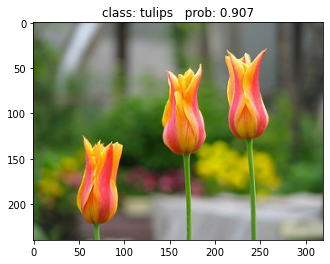

In [42]:
predict_model(img        = "./dataset/flower_photos/tulips/146884869_b1a8fa9c4e_n.jpg",
              label_json = './class_indices.json',
              weights    = "./weights/model-29.pth", )

---

# Result

### Train Acc
<img src="Assets/Result/train_acc.png" width="20%" style = "float: left"/>

### Train Loss
<img src="Assets/Result/train_loss.png" width="20%" style = "float: left"/>

### Valid Acc
<img src="Assets/Result/val_acc.png" width="20%" style = "float: left"/>

### Valid Loss
<img src="Assets/Result/val_loss.png" width="20%" style = "float: left"/>

### Learning Rate
<img src="Assets/Result/learning_rate.png" width="20%" style = "float: left"/>